In [37]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from BaselineRemoval import BaselineRemoval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import TensorDataset
import torch
from torch import nn
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from torch.utils.data import TensorDataset


In [38]:
DATALABEL = ['ear lobe','inner arm','thumb nail','median cubital vein']
WATCH_PROB_PREDICT = False ## if you want to observe the probability of each choice
PLT = '/root/projects/ProjectAug22/CP/Diabete_detection_withRamanSpec/dataset/' ## change to the path to dataset
PLT_mac = '/Volumes/ExternalSSDForMac/AITLecture/CSforDSAIAUG22/_CP_project/DataScienceAndMLProjects/Diabete_detection_withRamanSpec/dataset'

SMOOTH = False

SEED = 25811243



## 1. ETL

In [39]:
from src import spectrumloader as spl
from src import get_torch_loader as tlg
from src.modeltorch_template import NeuralNet,RamConv1d,RamLSTM,RamConv1d_bnmx,IntANN,IntRamLSTM,RamConv1d_mx
from src import trainResult_show as mtp

In [40]:
standard,data_all = spl.read_file('dataset/')

In [41]:
Xs,ys,_ = spl.cut_tonumpy(data_all)

In [42]:
assert len(Xs) == 4, 'DATA error'

## 2.Train test split (with same seed)

In [43]:
X_trainall,_,y_trainall,_ = spl.split_train_test(Xs,ys)
y_train0,y_train1,y_train2,y_train3 = y_trainall

In [44]:
y_train0,y_train1,y_train2,y_train3

(array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.]),
 array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.]),
 array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.]),
 array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.]))

## 3. EDA [here](https://github.com/AtiChetsurakul/DataScienceAndMLProjects/blob/main/Diabete_detection_withRamanSpec/datawatcher.ipynb)
- To shorten the file, eda not inculded

## 4. spectrum tranformation 
- incuding
    - Fluoresence removal
    - Correcting baseline
    - Normalization
## ORDER OF DATA ARE
>(0) ear lobe

>(1) inner arm 

>(2) thumb nail 

>(3) median cubital vein


In [45]:
X_train_VR = spl.fluoresence_removal(X_trainall)
if SMOOTH:
    X_train_VR = spl.savitzky_smooth(X_train_VR)

In [46]:
X_train0_std,X_train1_std,X_train2_std,X_train3_std,normalizer = spl.seting_normalized_fuoresence_smoothing(True,True,X_train_VR)

assert len(normalizer) == 4, 'Normalizer is not here'

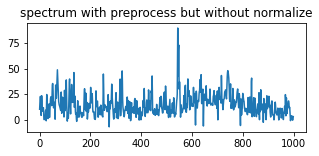

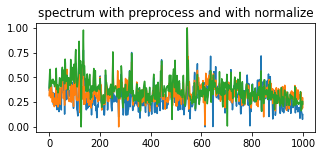

In [47]:
# Check by plot
plt.figure(figsize=(5,2))
plt.plot(X_train_VR[0][0])
plt.title('spectrum with preprocess but without normalize')
plt.show()
plt.figure(figsize=(5,2))
plt.title('spectrum with preprocess and with normalize')
plt.plot(X_train1_std[0])
plt.plot(X_train1_std[7])
plt.plot(X_train1_std[2])

plt.show()

In [48]:
X_train0_std.reshape((16,1,-1)).shape

(16, 1, 1000)

In [49]:
X_all_newdim = np.concatenate((X_train0_std.reshape((16,1,-1)),X_train1_std.reshape((16,1,-1)),X_train2_std.reshape((16,1,-1)),X_train3_std.reshape((16,1,-1))),axis = 1)

In [50]:
X_all_newdim.shape

(16, 4, 1000)

In [73]:
ds_4stack = TensorDataset(torch.FloatTensor(X_all_newdim),torch.LongTensor(y_train0))
train_setstack, val_setstack = torch.utils.data.random_split(ds_4stack, [12, 4])


In [74]:
batch_size = 12
valbatch_size = 4

train_size = 12
val_size = 4

train_loaderstack = torch.utils.data.DataLoader(dataset=train_setstack,batch_size=batch_size,shuffle=True)
val_loaderstack = torch.utils.data.DataLoader(dataset=val_setstack, batch_size=valbatch_size, shuffle=True)

In [75]:
for i,j in train_setstack:
    print(j)



tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)


In [76]:
for i,j in val_setstack:
    print(j)

tensor(0)
tensor(1)
tensor(1)
tensor(0)


In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [78]:
class RamConv1d_mx(nn.Module):
    def __init__(self, input_size = 1, hidden_size=10,hidden_size2=50,linear_hidden=14, out_size=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size = 3)      
        self.relu1 = nn.ReLU()                            
        # Convolution Layer 2
        self.conv2 = nn.Conv1d(hidden_size, hidden_size2, kernel_size = 3)     
        self.maxpool1 = nn.MaxPool1d(2)
        self.maxpool2 = nn.MaxPool1d(2)                   
        self.relu2 = nn.ReLU()                           
        self.drop = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(12400, 2)
        # self.fc2 = nn.Linear(1000, linear_hidden)
        self.fc3 = nn.Linear(linear_hidden, out_size)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                                                    
        x = self.relu1(x)
        x = self.maxpool1(x) 
        # Convolution Layer 2
        x = self.conv2(x)  
        x = self.relu2(x)             
        x = self.maxpool2(x)

        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        # x = self.relu1(x)

        # x = self.drop(x)
        # x = self.fc2(x)
        # x = self.relu1(x)
        return x

In [79]:
modelcnn_for_4stack = RamConv1d_mx(input_size = 4).to(device)



criterion_for_4stack = nn.CrossEntropyLoss()   
optimizer_for_4stack = torch.optim.Adam(modelcnn_for_4stack.parameters(), lr=0.0000001)  

 

cnnINTsim_models = [modelcnn_for_4stack]
cnnINTsim_criterions = [criterion_for_4stack]
cnnINTsim_optims = [optimizer_for_4stack]
train_loader_all = [train_loaderstack]
val_loader_all = [val_loaderstack]

In [80]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(cnnINTsim_models,cnnINTsim_criterions,cnnINTsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            model.train()

            spec = spec.reshape(spec.shape[0],spec.shape[1],-1).to(device)
            # print(spec.shape)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            model.eval()
            with torch.no_grad():
                total_train_corr = 0
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],spec.shape[1],-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())
                    train_pred = torch.max(outputs, 1)[1]
                    total_train_corr += (train_pred == y).sum()
                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                train_acc = (total_train_corr * 100) / train_size
                print(f"     train_acc {train_acc:.2f}  ++Validation++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)
    

Epoch [5000/5000], Step [1/1.0], Loss: 0.6804     train_acc 75.00  ++Validation++  Loss: 0.70 - Acc: 50.00 
 END OF MODEL for ear lobe with val acc = 50.0


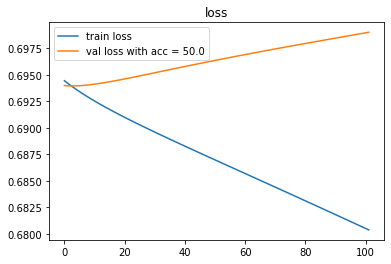

In [81]:
for trainloss, valloss, valacc in zip(train_loss_each_location, val_loss_each_location, val_acc_each_location):
    plt.plot(trainloss, label=f'train loss')
    plt.plot(valloss, label=f'val loss with acc = {valacc}')
    plt.title('loss')
    plt.legend()

        # pass
plt.show()